In [1]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
# torch.multiprocessing.set_start_method('spawn')
import gym_lite6.env, gym_lite6.pickup_task
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
# import mujoco

env: MUJOCO_GL=egl # Had to export this before starting jupyter server


""

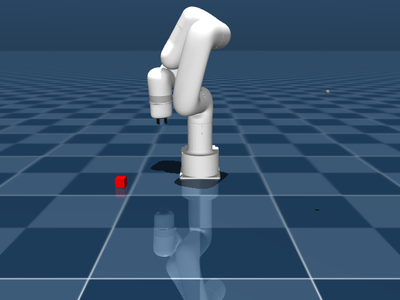

In [2]:
from importlib import reload
reload(gym_lite6.env)

task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render(), width=400)



""

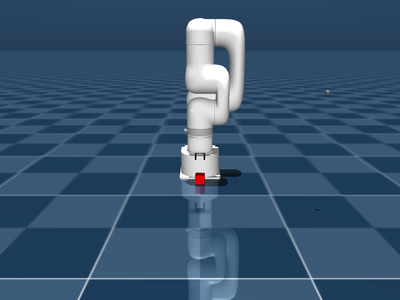

In [4]:
observation, info = env.reset(qpos=np.array([0, 0, 0, 0, 0, 0]), box_pos=np.array([0.1, 0, 0.0]))
media.show_image(env.render(), width=400)

In [5]:
import datasets
# datasets.config.IN_MEMORY_MAX_SIZE = 16*1024*1024
from datasets import load_from_disk
from pathlib import Path

dataset_path = Path(__vsc_ipynb_file__).parent /"datasets/grasp_100_2024-09-06_17-03-47.hf"
dataset = load_from_disk(str(dataset_path))


In [8]:
episode_idx = 1

episode_data = dataset.filter(lambda example: example['episode_index'] == episode_idx)

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [9]:

replay_frames = []
orig_frames = []
gripper_frames = []
observation, info = env.reset(qpos=episode_data["action.qpos"][0])
for data in episode_data:
    action = {"gripper": data["action.gripper"], "qpos": data["action.qpos"]}
    # print(action)
    observation, reward, terminated, truncated, info = env.step(action)
    # print(observation)
    replay_frames.append(observation["pixels"]["side"])
    orig_frames.append(np.array(data["observation.pixels.side"]))
    gripper_frames.append(np.array(data["observation.pixels.gripper"]))
    # orig_frames.append(data["observation.pixels.side"])

media.show_videos([replay_frames, orig_frames, gripper_frames])

In [20]:
type(observation["pixels"]["side"])

numpy.ndarray

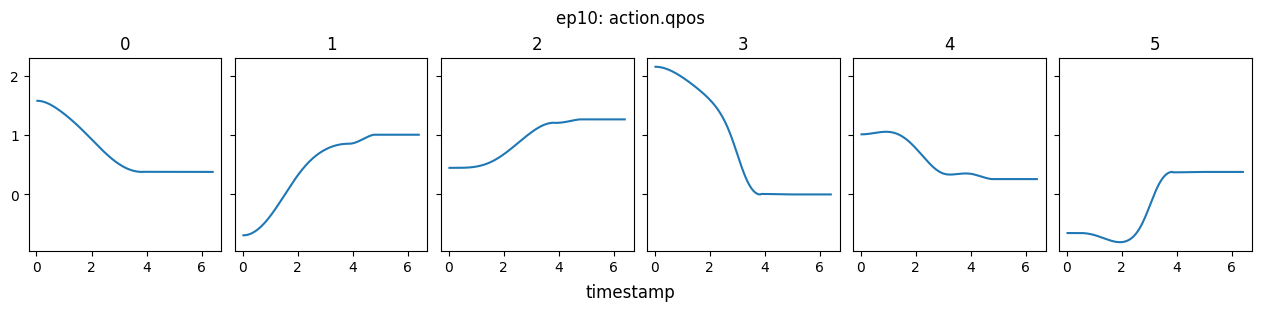

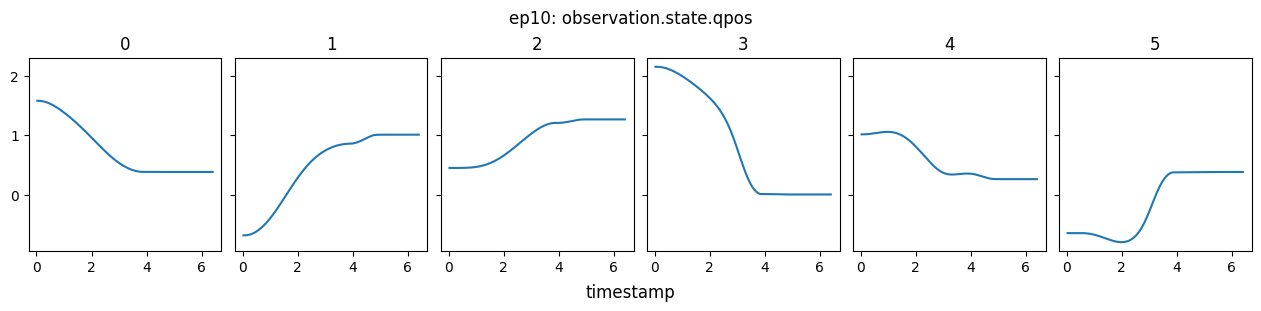

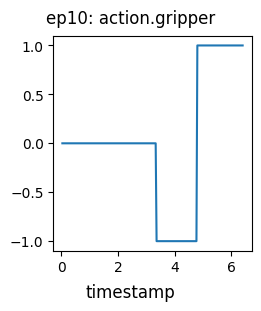

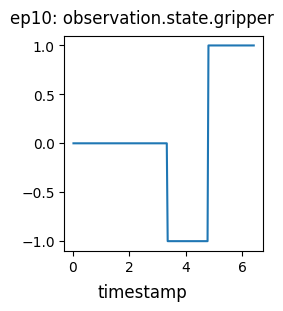

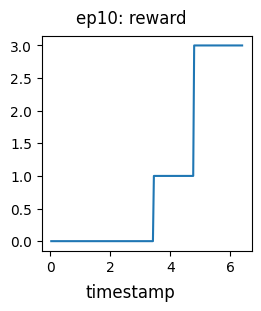

In [8]:
import matplotlib.pyplot as plt

vars = ['action.qpos', 'observation.state.qpos', 'action.gripper', 'observation.state.gripper', 'reward']
xax = 'timestamp'
for var in vars:
  if hasattr(episode_data[0][var], '__iter__'):
    len_state = len(episode_data[0][var])
  else:
    len_state = 1
  ncols = len_state; nrows= int(np.ceil(len_state/ncols))
  plt_data = torch.tensor(episode_data[var])
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(ncols*2+0.5, nrows*2+1), constrained_layout=True)

  for i in range(len_state):
    # ax = plt.subplot(int(np.ceil(len_qpos/3)), 3, i+1)
    if len_state > 1:
      ax = axs.flatten()[i]
      ax.plot(episode_data[xax], plt_data[:, i])
      ax.set_title(i)
    else:
      ax = axs
      ax.plot(episode_data[xax], plt_data)

  # fig.add_subplot(111, frameon=False)
  plt.suptitle(f"ep{episode_idx}: {var}")
  # fig.supylabel("Joint angle")
  fig.supxlabel(xax)
  # plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  # fig.tight_layout()


In [9]:
episode_data

Dataset({
    features: ['action.qpos', 'action.gripper', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.pixels.side', 'observation.pixels.gripper', 'reward', 'timestamp', 'episode_index', 'frame_index', 'index'],
    num_rows: 200
})

In [5]:
dataset["test"] = np.array([0, 3, 4])

TypeError: 'Dataset' object does not support item assignment